# SpecieScan: Automated Species Identification Algorithm for Bone Fragments from MALDI-ToF MS Spectra 

v0.2.0

## All data read in to this code should be preprocessed with the SpecieScan R code

For usage and guidance see README.md in the SpecieScan Python repo and comments within this notebook.

Cite paper: Végh & Douka 2023. SpecieScan: Semi-Automated Species Identification of Bone Collagen Peptides from MALDI-ToF MS SpectraBioinformatics 40(2), 1-12.

& cite Github DOI: 10.5281/zenodo.8055426

License: MIT

Contact: Emese Végh[mesve3@gmail.com]


In [7]:
import pandas
pd=pandas
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from matplotlib import rcParams
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline
from scipy.ndimage import gaussian_filter1d
import csv

import ntpath
from pathlib import Path


import os
import glob

## Read in an unknown sample and the geographically-relevant reference database for the first expected animal class (e.g., Mammalia)

In [3]:
# Read in unknown sample's preprocessed peaks as csv
df = pd.read_csv("/path/to/folder/DC15223_C6.csv", sep=',')

# Define fields/columns of the reference database (check if correct for the reference database used)
fields = ['Order', 'Family', 'Species', 'ZooMS_taxon', 'COL1_1_508_519', 'COL1_2_978_990', 'COL1_2_978_990_16', 'COL1a2_484___499', 'COL1a2_502___519', 'COL1a2_292___309', 'COL1a2_793___816', 'COL1a2_454___483', 'COL1a1_586___618', 'COL1a1_586___618_16', 'COL1a2_757___789', 'COL1a2_757___789_16']

# Read in the geographically relevant reference database
reference = pd.read_csv('/path/to/folder/ZooMS_reference_db_eurasia_with_taxon.csv', sep=",", encoding='UTF-8', header=None, names=fields)
peak_markers = list(reference.columns)[4:]

ref_peaks = reference[peak_markers].drop(0, axis=0).astype(float)

In [4]:
# Check if reference peaks only contains the peak markers
ref_peaks.head()

,COL1_1_508_519,COL1_2_978_990,COL1_2_978_990_16,COL1a2_484___499,COL1a2_502___519,COL1a2_292___309,COL1a2_793___816,COL1a2_454___483,COL1a1_586___618,COL1a1_586___618_16,COL1a2_757___789,COL1a2_757___789_16
1,1079.6,NaN,1205.6,1453.7,1566.8,1682.8,2135.1,NaN,2883.4,NaN,NaN,3023.4
2,1079.6,NaN,1205.6,1453.7,1566.8,1682.8,2135.1,NaN,2883.4,NaN,NaN,3023.4
3,1079.6,NaN,1205.6,1441.7,1550.8,1652.8,2135.1,NaN,2883.4,NaN,NaN,3023.4
4,1079.6,NaN,1205.6,1453.7,1550.8,1652.8,2105.1,NaN,2883.4,NaN,NaN,3023.4
5,1079.6,NaN,1205.6,1453.7,1566.8,1652.8,2135.1,NaN,2883.4,NaN,NaN,3023.4


## Run script to identify species and peptide markers in one sample


In [5]:
# function with one sample
def transform(df):
    df_copy = df.copy() # making a copy so I dont have to reload the dataframe everytime
    #then changes are made to df_copy   
    x = np.arange(500, 3500, 0.1)
    pi = np.array(ref_peaks.iloc[0].to_numpy())
    pi = pi[~np.isnan(pi)]      
    resampled = np.zeros_like(x)
    for p in df_copy['mass']:
        resampled[np.logical_and(p-x>-0.3,p-x<1.3)] = 1
        
    resampled_smooth = gaussian_filter1d(resampled, 100)
    plt.plot(x, resampled, label='sample', linewidth=1)
    plt.plot(x, resampled_smooth, label='sample', linewidth=1)
    
    n_spec = ref_peaks.shape[0]
    corrs = np.zeros(n_spec)
    for i in range(n_spec):
        y = np.zeros_like(x)
        pi = np.array(ref_peaks.iloc[i].to_numpy())
        pi = pi[~np.isnan(pi)]
        for p in pi:
            y[np.logical_and(p-x>-0.3,p-x<1.3)] = 1
            corrs[i] = np.corrcoef(y, resampled)[0,1]
        ranks = pd.DataFrame({'Order':reference['Order'][1:],'Family':reference['Family'][1:], 'Species':reference['Species'][1:], 'ZooMS_taxon':reference['ZooMS_taxon'][1:], 'Correlation':corrs})
    
    idx = ranks.sort_values(by='Correlation', ascending=False).index[:6] - 1
    # index [6] because the first 6 matches of species will be determined -- number depends on how many of the first n most likely species you want to look at
    
    all_d = pd.DataFrame(columns=ref_peaks.columns)
    for i in idx:
        y = np.zeros_like(x)
        pi = np.array(ref_peaks.iloc[i].to_numpy())
        pi = pi[~np.isnan(pi)]
        for p in pi:
            y[np.logical_and(p-x>-0.3,p-x<1.3)] = 1
        
        plt.figure()
        plt.plot(x, y * resampled)
        plt.title(reference['Species'][i+1]);

        v, ix, iy = np.intersect1d((np.round(pi, decimals=1)*10).astype(int), (x[y*resampled==1]*10).astype(int), return_indices=True)
 
        d = pd.DataFrame({k:p for k, p in zip(ref_peaks.columns[ix],v/10)}, 
                 index=pd.MultiIndex.from_tuples([(reference['Species'][i+1], reference['Family'][i+1], reference['Order'][i+1], reference['ZooMS_taxon'][i+1])],
                                                 names=['Species', 'Family', 'Order', 'ZooMS_taxon'])).reset_index()

        all_d = pd.concat([all_d, d], axis=0)
    
    ranks_df = ranks.sort_values(by='Correlation', ascending=False)

    
    return all_d

,COL1_1_508_519,COL1_2_978_990,COL1_2_978_990_16,COL1a2_484___499,COL1a2_502___519,COL1a2_292___309,COL1a2_793___816,COL1a2_454___483,COL1a1_586___618,COL1a1_586___618_16,COL1a2_757___789,COL1a2_757___789_16,Species,Family,Order,ZooMS_taxon
0,1105.6,1453.7,NaN,2115.1,NaN,2853.4,NaN,NaN,NaN,NaN,NaN,NaN,Mammuthus trogontherii,Elephantidae,Proboscidea,Mammoth/Elephas
0,1105.6,NaN,1453.7,NaN,2115.1,NaN,2853.4,NaN,NaN,NaN,NaN,NaN,Elephas maximus indicus,Elephantidae,Proboscidea,Mammoth/Elephas
0,1105.6,NaN,NaN,1453.7,NaN,NaN,2115.1,NaN,2853.4,NaN,NaN,NaN,Palaeoloxodon antiquus,Elephantidae,Proboscidea,Mammoth/Elephas
0,1105.6,NaN,NaN,1453.7,NaN,NaN,2115.1,NaN,2853.4,NaN,NaN,NaN,Elephas maximus,Elephantidae,Proboscidea,Mammoth/Elephas
0,1105.6,NaN,NaN,1453.7,NaN,NaN,2115.1,NaN,2853.4,NaN,NaN,NaN,Mammuthus primigenius,Elephantidae,Proboscidea,Mammoth/Elephas
0,1105.6,NaN,NaN,1453.7,NaN,NaN,2853.4,NaN,NaN,NaN,NaN,NaN,Eumetopias jubatus,Otariidae,Carnivora,Arctocephalus/Callorhinus/Eumetopias/Zalophus/...


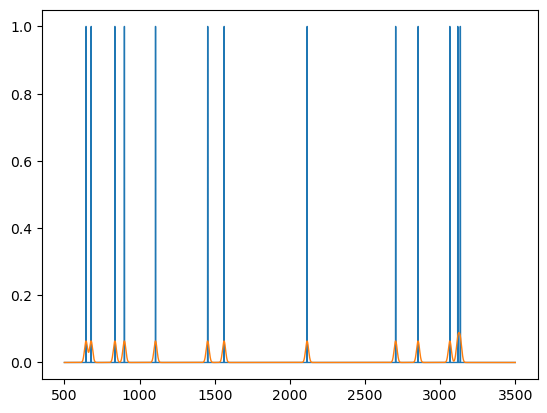

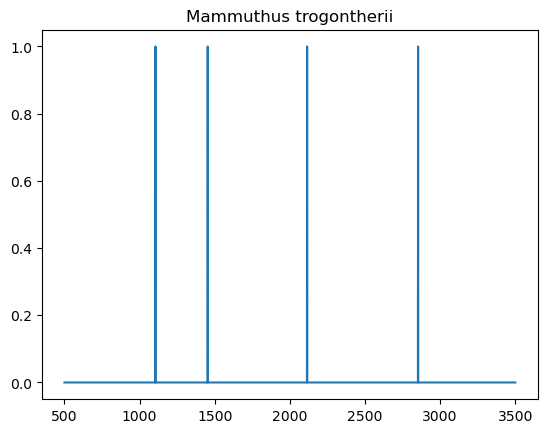

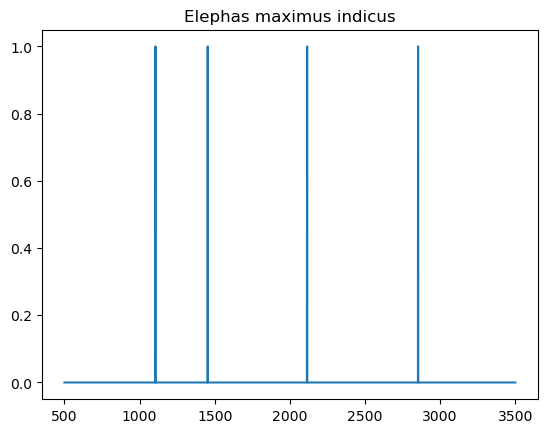

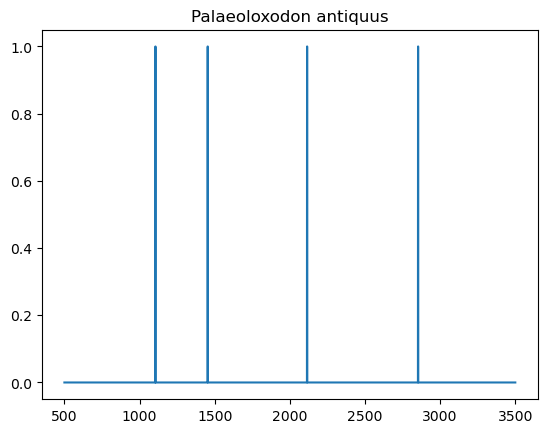

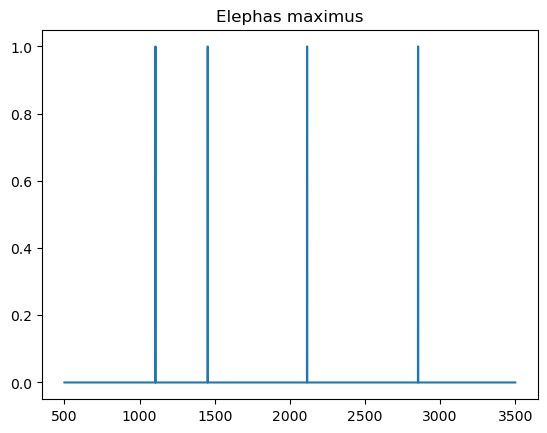

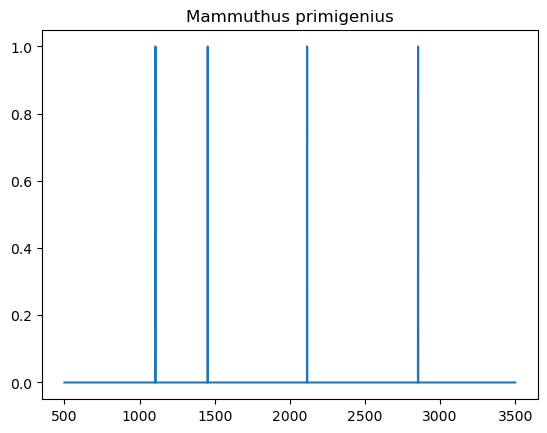

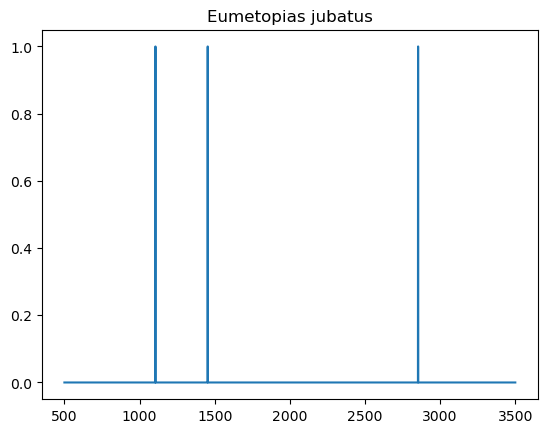

In [6]:
transform(df) # this carries out the previous function and shows you the peptide markers and species for the read in sample

## Batch processing with the transform function

In [ ]:
# Before running this: make a new folder with all the pre-processed .csv files of the unknown samples
# Batch process the whole folder
# Batch process all csv files in a folder
folder_path = "/path/to/folder/Batch_all_d" # Replace with the actual path to the folder
all_files = glob.glob(folder_path + "/*.csv")

for path in all_files:
    print(f"Processing: {path}")  # This will help debugging, if one of the samples fail
    df = pd.read_csv(path)
    df_transformed = transform(df)

    path_no_csv = path.replace(".csv", "")  # Removes .csv at the end of path
    save_path = path_no_csv + "_all_d.csv"  # Adds the suffix you want (e.g., peptide_species_results.csv)
    df_transformed.to_csv(save_path)
# Once running this, it will make new csv files with the results in the folder you created
# when all samples have been transformed, check if all files have been transformed and in the correct folder
# Wait for this step to finish before moving on to the next step

In [10]:
# Delete all csv-s in folder that does not contain 'all_d' (or the suffix you defined before, e.g. 'all_d' or 'peptide_species_results') in the file name (this will be useful for concatenating)

folder_path = "/path/to/folder/Batch_all_d"  # Replace with the actual path to the folder

for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "_all_d" not in filename:
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print("Failed to delete file:", e)

# Once ran, check if the original files are deleted from the new folder and only the _all_d.csv files are kept

In [ ]:
# Concatenate all the new results (all_d) files (that you just created)
folder_path = '/path/to/folder/Batch_all_d'

# create an empty list to store dataframes
dfs = []

# loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        # read the CSV file into a dataframe
        df = pd.read_csv(os.path.join(folder_path, filename))
        # add a new column with the file name as the value
        df["filename"] = filename
        # append the dataframe to the list
        dfs.append(df)

# concatenate all dataframes in the list into a single dataframe
merged_all_d = pd.concat(dfs, ignore_index=True)

# Make filename the index
merged_all_d = merged_all_d.set_index('filename')

# Drop Unnamed column
merged_all_d.drop('Unnamed: 0', axis=1, inplace=True)

# Drop the additional info in the name of the samples
merged_all_d.index = merged_all_d.index.str.split('_').str[0]

merged_all_d = merged_all_d.reset_index().rename(columns={'filename': 'Sample'})


merged_all_d.to_csv("/path/to/folder/merged_all_d.csv", sep=',') # save the merged all_d files
merged_all_d

## Create the correlation scores for one sample

In [18]:
# transform one spectrum with species and correlation scores
df = pd.read_csv("/file/to/path/filename.csv", sep=',') # same sample's spectrum you read in the first time (copy paste from the top where you define df)


def transform_correlation(df):
    df_copy = df.copy()  # making a copy again so I don't have to reload the dataframe every time
    x = np.arange(500, 3500, 0.1)
    pi = np.array(ref_peaks.iloc[0].to_numpy())
    pi = pi[~np.isnan(pi)]
    resampled = np.zeros_like(x)
    
    for p in df_copy['mass']:
        resampled[np.logical_and(p - x > -0.3, p - x < 1.3)] = 1

    resampled_smooth = gaussian_filter1d(resampled, 100)
    plt.plot(x, resampled, label='sample', linewidth=1)
    plt.plot(x, resampled_smooth, label='sample', linewidth=1)

    n_spec = ref_peaks.shape[0]
    corrs = np.zeros(n_spec)
    
    for i in range(n_spec):
        y = np.zeros_like(x)
        pi = np.array(ref_peaks.iloc[i].to_numpy())
        pi = pi[~np.isnan(pi)]
        
        for p in pi:
            y[np.logical_and(p - x > -0.3, p - x < 1.3)] = 1
            corrs[i] = np.corrcoef(y, resampled)[0, 1]
        
        ranks = pd.DataFrame({'Order': reference['Order'][1:], 'Family': reference['Family'][1:], 
                              'Species': reference['Species'][1:], 'ZooMS_taxon': reference['ZooMS_taxon'][1:], 
                              'Correlation': corrs})
    
    idx = ranks.sort_values(by='Correlation', ascending=False).index[:6] - 1
    
    all_d = pd.DataFrame(columns=['Order', 'Family', 'Species', 'ZooMS_taxon'] + list(ref_peaks.columns))
    
    for i in idx:
        y = np.zeros_like(x)
        pi = np.array(ref_peaks.iloc[i].to_numpy())
        pi = pi[~np.isnan(pi)]
        
        for p in pi:
            y[np.logical_and(p - x > -0.3, p - x < 1.3)] = 1
        
        plt.figure()
        plt.plot(x, y * resampled)
        plt.title(reference['Species'][i + 1])

        v, ix, iy = np.intersect1d((np.round(pi, decimals=1) * 10).astype(int),
                                   (x[y * resampled == 1] * 10).astype(int), return_indices=True)
        
        d = pd.DataFrame({k: p for k, p in zip(ref_peaks.columns[ix], v / 10)}, 
                         index=[reference['Species'][i + 1]])
        
        d['Order'] = reference['Order'][i + 1]
        d['Family'] = reference['Family'][i + 1]
        d['Species'] = reference['Species'][i + 1]
        d['ZooMS_taxon'] = reference['ZooMS_taxon'][i + 1]
        
        all_d = pd.concat([all_d, d], axis=0)
    
    ranks_df = ranks.sort_values(by='Correlation', ascending=False).head(6)
    results_concated = pd.concat([all_d, ranks_df], axis=1)
    
    return ranks_df


,Order,Family,Species,ZooMS_taxon,Correlation
134,Proboscidea,Elephantidae,Mammuthus trogontherii,Mammoth/Elephas,0.296433
132,Proboscidea,Elephantidae,Elephas maximus indicus,Mammoth/Elephas,0.280685
135,Proboscidea,Elephantidae,Palaeoloxodon antiquus,Mammoth/Elephas,0.255249
131,Proboscidea,Elephantidae,Elephas maximus,Mammoth/Elephas,0.255249
133,Proboscidea,Elephantidae,Mammuthus primigenius,Mammoth/Elephas,0.255249
76,Carnivora,Otariidae,Eumetopias jubatus,Arctocephalus/Callorhinus/Eumetopias/Zalophus/...,0.216404


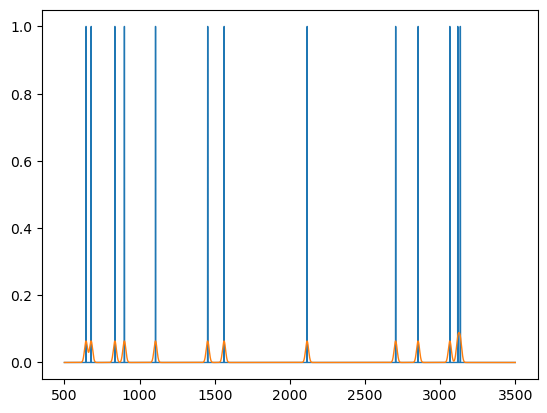

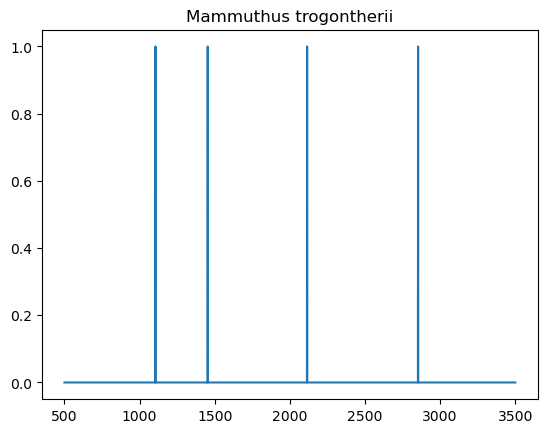

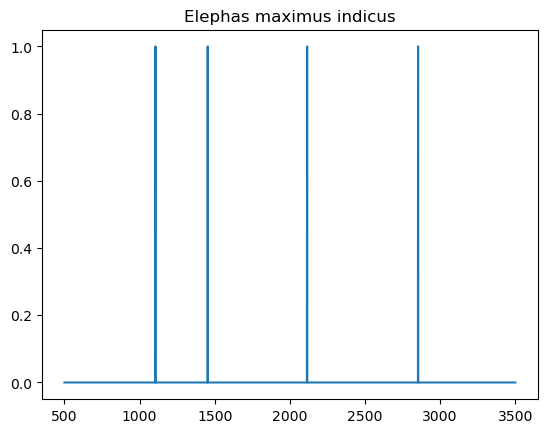

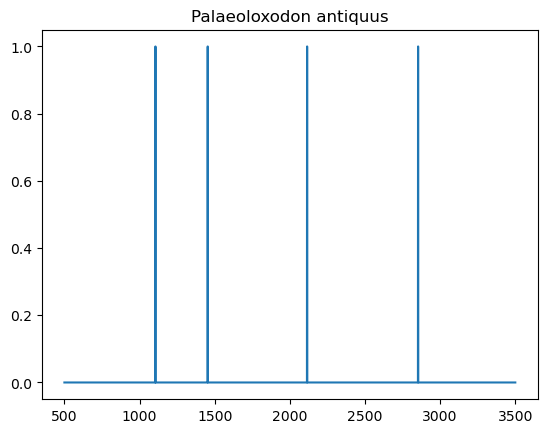

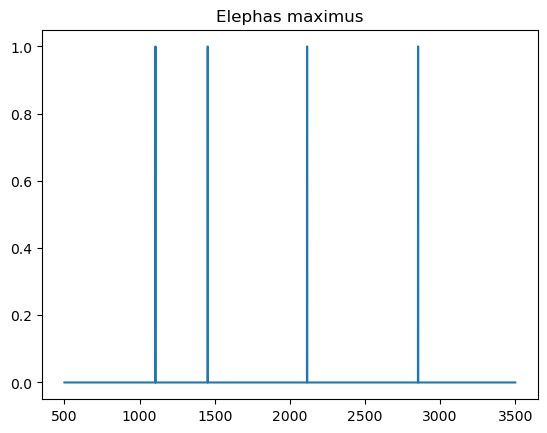

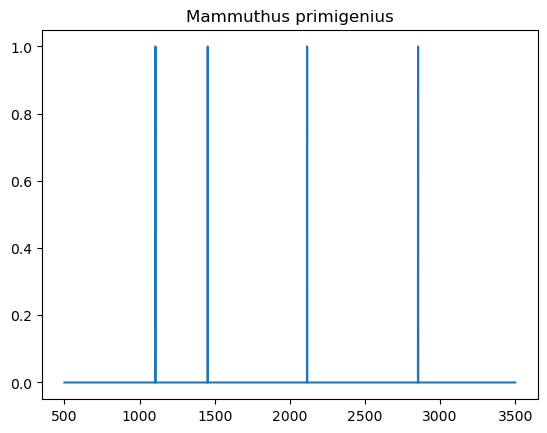

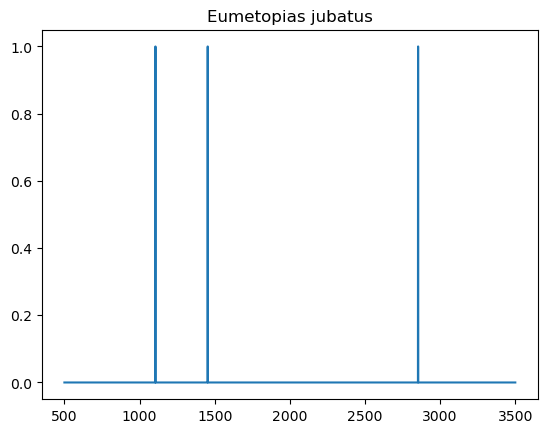

In [19]:
# Run the previously defined transform_correlation function for correlation scores
transform_correlation(df)

# If it only shows you the above defined n number of species, it worked (default example: 6).

## Batch process with transform_correlation

In [ ]:
# Make a new folder with original preprocessed peaks to transform the files in a batch to similarity scores -- e.g., call it batch_name_corr6
path = "/path/to/folder/batch_name_corr6"
all_files = glob.glob(path + "/*.csv")

for path in all_files: #no need for the number
    print(f"Processing: {path}") # this will help debugging
    df = pd.read_csv(path)
    df_transformed_corr = transform_correlation(df)

    path_no_csv = path.replace(".csv", "") #removes .csv at the end of path
    save_path = path_no_csv + "_corr6.csv" #adds the suffix you want (here it is corr 6 because it shows the highest correlated species for the first 6 species)
    df_transformed_corr.to_csv(save_path)

# Wait for it to finish and only move forward when all samples have been analysed
# Check if all files have been transformed

In [25]:
# Delete all csv-s in folder that does not contain 'corr6' in the file name (this will be useful for concatenating)

folder_path = "/path/to/folder/batch_name_corr6"  # Replace with actual path to folder


for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "_corr6" not in filename:
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print("Failed to delete file:", e)

# Check folder if all non corr6.csv files were deleted

In [ ]:
# Merge all corr6 (files with correlation scores)
folder_path = "/path/to/folder/batch_name_corr6" # Replace with actual path to folder


# create an empty list to store dataframes
dfs = []

# loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        # read the csv file into a dataframe
        df = pd.read_csv(os.path.join(folder_path, filename))
        # add a new column with the file name as the value
        df["filename"] = filename
        # append the dataframe to the list
        dfs.append(df)

# concatenate all dataframes in the list into a single dataframe
merged_corr6 = pd.concat(dfs, ignore_index=True)

# Make filename the index
merged_corr6 = merged_corr6.set_index('filename')

# Drop Unnamed column
merged_corr6.drop('Unnamed: 0', axis=1, inplace=True)

# Drop the additional info in the name of the samples if you have spot number information included in the filenames
merged_corr6.index = merged_corr6.index.str.split('_').str[0]

merged_corr6 = merged_corr6.reset_index().rename(columns={'filename': 'Sample'})

merged_corr6.to_csv('/path/to/file/xxx_corr6_merged.csv', sep=',')


## Concatenate the merged all_d and corr6 files 

In [ ]:
#Merging the results of transform_correlation(df) and transform(df) -- aka all_d_merged and corr6_merged

# Merge the two dataframes on common columns
merged_results = merged_all_d.merge(merged_corr6[['Sample', 'Order', 'Family', 'Species', 'ZooMS_taxon', 'Correlation']], 
                                 on=['Sample', 'Order', 'Family', 'Species', 'ZooMS_taxon'], 
                                 how='left')
merged_results.to_csv('path/to/folder/Batch_Speciescan_results.csv', sep=',')

## End of code for automated species identification. The file just merged contains the peptide markers present, ZooMS taxon, Species, Family, Order, and correlation scores for all samples.

## Scan for Contaminants

In [ ]:
# Check for contaminations in one unknown sample (e.g., the one that was read in -- df)
df = pandas.read_csv("/path/to/folder/samplenumber_A1.csv", sep=',')

##Match mass to contaminants

# Load the contaminants csv data
contaminants = pd.read_csv('/path/to/older/contaminants_reference.csv') # find this file on the SpecieScan Zenodo repository

# Define a tolerance (±0.3 accounting for the MALDI -- you can change this)
tolerance = 0.3

# Check for matches within tolerance
matching_contaminants = contaminants[contaminants['mass'].apply(lambda x: any(np.isclose(x, df['mass'], atol=tolerance)))]

# Print the matching contaminants
print(matching_contaminants)


## Batch process for contaminants

In [ ]:
# Contaminants batch analysis

# Load the contaminants csv again
contaminants = pd.read_csv('/path/to/folder/contaminants_reference.csv')

# Define a tolerance (e.g., ±0.3 accounting for the MALDI)
tolerance = 0.3

# Batch process files
## Make a new folder for the contaminants csv-s and copy all the pre-processed samples in it that you want to analyse
path = "/path/to/folder/contaminants" # this needs to contain all the pre-processed csv files
all_files = glob.glob(path + "/*.csv")

for csv_file in all_files:
    print(f"Processing: {csv_file}")
    
    # Load the csv file
    df = pd.read_csv(csv_file)
    
    # Check for matches within the specified tolerance
    matching_contaminants = contaminants[contaminants['mass'].apply(lambda x: any(np.isclose(x, df['mass'], atol=tolerance)))]
    
    # Define the save path
    csv_file_no_extension = csv_file.replace(".csv", "")
    save_path = csv_file_no_extension + "_Contaminants.csv"
    
    # Save the matched contaminants DataFrame
    matching_contaminants.to_csv(save_path)


In [ ]:
# Delete all csv-s in folder that does not contain 'contaminants'

folder_path = "/path/to/folder/contaminants"  # Replace with actual path to folder

for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "_Contaminants" not in filename:
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print("Failed to delete file:", e)
# Once ran, check if the original files are deleted from the new folder and the new results are kept

In [ ]:
# Concatenate all the new results files 
folder_path = '/path/to/folder/contaminants'

# create an empty list to store dataframes
dfs = []

# loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        # read the .csv file into a dataframe
        df = pd.read_csv(os.path.join(folder_path, filename))
        # add a new column with the file name as the value -- you can change the name of the column to something other than filename
        df["filename"] = filename
        # append the dataframe to the list
        dfs.append(df)
# Concatenate all dataframes in the list into a single dataframe
merged_df = pd.concat(dfs, ignore_index=True)

# Make filename the index
merged_df = merged_df.set_index('filename')

# Drop Unnamed column
merged_df.drop('Unnamed: 0', axis=1, inplace=True)


# Drop the additional info in the name of the samples -- if needed
#merged_df.index = merged_df.index.str.split('_').str[0]

merged_contaminants = merged_df.rename_axis("Sample")
merged_contaminants
merged_contaminants.to_csv("/path/to/folder/Batch_contaminants.csv")

# End of SpecieScan code
-----------------------------------------

## Individual Samples to make changes to the code
If you want to make changes to the code and play around with values, use the following code. This will not batch process files

In [ ]:
x = np.arange(500, 3500, 0.1)
y = np.zeros_like(x)
pi = np.array(ref_peaks.iloc[0].to_numpy())
for p in pi:
    y[np.logical_and(p-x>0.3,p-x<1.3)] = 1

In [ ]:
x = np.arange(500, 3500, 0.1)
#resampled = reconstructed sample's spectra
resampled = np.zeros_like(x)
for p in df_f9['mass']:
    resampled[np.logical_and(p-x>-0.3,p-x<1.3)] = 1
resampled_smooth = gaussian_filter1d(resampled, 100)
plt.plot(x, resampled, label='sample', linewidth=1)
plt.plot(x, resampled_smooth, label='sample', linewidth=1)

In [ ]:
x = np.arange(500, 3500, 0.1)
resampled = np.zeros_like(x)
for p in df_f9['mass']:
    resampled[np.logical_and(p-x>-0.3,p-x<1.3)] = 1

plt.plot(x, resampled, label='sample', linewidth=1)
corrs = np.zeros(3)

for i in range(3):
    y = np.zeros_like(x)
    pi = np.array(ref_peaks.iloc[i].to_numpy())
    print(pi)
    for p in pi:
        y[np.logical_and(p-x>0.3,p-x<1.3)] = 1
    plt.plot(x, y, label=reference['Species'][i+1])
    corrs[i] = np.corrcoef(y, resampled)[0,1]
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3);

In [ ]:
n_spec = ref_peaks.shape[0]
corrs = np.zeros(n_spec)
for i in range(n_spec):
    y = np.zeros_like(x)
    pi = np.array(ref_peaks.iloc[i].to_numpy())
    for p in pi:
        y[np.logical_and(p-x>-0.3,p-x<1.3)] = 1
    corrs[i] = np.corrcoef(y, resampled)[0,1]
ranks = pandas.DataFrame({'common':reference['Common_name'][1:],'names':reference['Species'][1:], 'correlation':corrs})

ranks.sort_values(by='correlation', ascending=False).style

In [ ]:
np.round(pi, decimals=2)

In [ ]:
idx = ranks.sort_values(by='correlation', ascending=False).index[:10]
# index [10] because the first 10 matches I want to look at

for i in idx:
    y = np.zeros_like(x)
    pi = np.array(ref_peaks.iloc[i].to_numpy())
    print(pi)
    for p in pi:
        y[np.logical_and(p-x>-0.3,p-x<1.3)] = 1
    plt.figure()
    plt.plot(x, y * resampled)
    print(reference['Species'][i+1])
    v, ix, iy = np.intersect1d((np.round(pi, decimals=1)*10).astype(int), (x[y*resampled==1]*10).astype(int), return_indices=True)
    print(v/10)
    print(ref_peaks.columns[ix])
    plt.title(reference['Species'][i+1]);


In [ ]:
#For debugging: here I tried printing just pi to see what is out of bounds
for i in idx:
    y = np.zeros_like(x)
    pi = np.array(ref_peaks.iloc[i].to_numpy())
    print(pi)

In [ ]:
idx = ranks.sort_values(by='correlation', ascending=False).index[:6]
all_d = pandas.DataFrame(columns=ref_peaks.columns)
for i in idx:
    y = np.zeros_like(x)
    pi = np.array(ref_peaks.iloc[i].to_numpy())
    for p in pi:
        y[np.logical_and(p-x>-0.3,p-x<1.3)] = 1
    print(reference['Species'][i+1])
    v, ix, iy = np.intersect1d((np.round(pi, decimals=1)*10).astype(int), (x[y*resampled==1]*10).astype(int), return_indices=True)
    d = pandas.DataFrame({k:p for k, p in zip(ref_peaks.columns[ix],v/10)}, index=[reference['Species'][i+1]])
    #print(d.transpose(), '\n')
    all_d = all_d.append(d)
all_d.style

